In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import glob
import seaborn as sns

In [2]:
TRAIN_IMAGE_ROOT = "/data/ephemeral/home/data/train/DCM"
TRAIN_LABEL_ROOT = "/data/ephemeral/home/data/train/outputs_json"
TEST_IMAGE_ROOT = "/data/ephemeral/home/data/test/DCM"

In [3]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

# 데이터셋 개요

####  폴더 개수 체크

In [4]:
train_image_folders = os.listdir(TRAIN_IMAGE_ROOT)
train_annotation_folders = os.listdir(TRAIN_LABEL_ROOT)
test_image_folders = os.listdir(TEST_IMAGE_ROOT)
print(f"Total Train Folders: {len(train_image_folders)}")
print(f"Total Train Annotation Folders: {len(train_annotation_folders)}")
print(f"Total Test Folders: {len(test_image_folders)}")

Total Train Folders: 400
Total Train Annotation Folders: 400
Total Test Folders: 144


#### train, test 폴더에 이미지 파일이 2개씩 존재하는지 체크

In [5]:
# Initialize a dictionary to store folder and image count information
folder_image_counts = {}

# Iterate through each folder and count the number of images
for folder in os.listdir(TRAIN_IMAGE_ROOT):
    folder_path = os.path.join(TRAIN_IMAGE_ROOT, folder)
    if os.path.isdir(folder_path):
        image_count = len([file for file in os.listdir(folder_path) if file.endswith('.png')])
        folder_image_counts[folder] = image_count

# Check for folders that do not have exactly 2 images
folders_with_issues = {folder: count for folder, count in folder_image_counts.items() if count != 2}

# Display the result
if folders_with_issues:
    print("Train folders with image count issues (not exactly 2 images):")
    for folder, count in folders_with_issues.items():
        print(f"Folder: {folder}, Image Count: {count}")
else:
    print("All train folders contain exactly 2 images.")

All train folders contain exactly 2 images.


In [6]:
# Initialize a dictionary to store folder and image count information
folder_image_counts = {}

# Iterate through each folder and count the number of images
for folder in os.listdir(TEST_IMAGE_ROOT):
    folder_path = os.path.join(TEST_IMAGE_ROOT, folder)
    if os.path.isdir(folder_path):
        image_count = len([file for file in os.listdir(folder_path) if file.endswith('.png')])
        folder_image_counts[folder] = image_count

# Check for folders that do not have exactly 2 images
folders_with_issues = {folder: count for folder, count in folder_image_counts.items() if count != 2}

# Display the result
if folders_with_issues:
    print("Test folders with image count issues (not exactly 2 images):")
    for folder, count in folders_with_issues.items():
        print(f"Folder: {folder}, Image Count: {count}")
else:
    print("All test folders contain exactly 2 images.")

All test folders contain exactly 2 images.


#### train 내 모든 이미지와 주석 매칭 확인

In [7]:
train_pngs = {
    os.path.relpath(os.path.join(root, fname), start=TRAIN_IMAGE_ROOT)
    for root, _dirs, files in os.walk(TRAIN_IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

train_jsons = {
    os.path.relpath(os.path.join(root, fname), start=TRAIN_LABEL_ROOT)
    for root, _dirs, files in os.walk(TRAIN_LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

test_pngs = {
    os.path.relpath(os.path.join(root, fname), start=TEST_IMAGE_ROOT)
    for root, _dirs, files in os.walk(TEST_IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [8]:
jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in train_jsons}
pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in train_pngs}

assert len(jsons_fn_prefix - pngs_fn_prefix) == 0
assert len(pngs_fn_prefix - jsons_fn_prefix) == 0

In [9]:
train_pngs = sorted(train_pngs)
train_jsons = sorted(train_jsons)
test_pngs = sorted(test_pngs)

#### json 파일 데이터 포맷 체크

In [ ]:
with open(os.path.join(TRAIN_LABEL_ROOT, train_jsons[0])) as f:
    annotation_json = json.load(f)
print(f"json 파일 key값: {annotation_json.keys()}")

json 파일 key값: dict_keys(['annotations', 'attributes', 'file_id', 'filename', 'parent_path', 'last_modifier_id', 'metadata', 'last_workers'])


In [ ]:
annotations = annotation_json["annotations"]
print(f"annotations key값: {annotations[1].keys()}")
print(f"'finger-1'의 annotations: {annotations[1]}")
print(f"annotations 개수: {len(annotations)}")

annotations key값: dict_keys(['id', 'type', 'attributes', 'points', 'label'])
'finger-1'의 annotations: {'id': '1-b517e5bb-f61b-4650-bda0-c2f983716c22', 'type': 'poly_seg', 'attributes': {}, 'points': [[463, 720], [462, 737], [471, 749], [485, 771], [497, 786], [505, 804], [508, 816], [510, 828], [507, 835], [508, 844], [517, 850], [531, 846], [543, 835], [561, 824], [570, 817], [570, 805], [562, 795], [554, 789], [544, 789], [512, 757], [513, 751], [508, 734], [496, 719], [487, 713], [476, 711], [467, 713]], 'label': 'finger-1'}
annotations 개수: 29


# 이미지 특성 분석

In [25]:
train_image_sizes = []
train_aspect_ratios = []

for image_path in train_pngs[:5]:
        with Image.open(os.path.join(TRAIN_IMAGE_ROOT, image_path)) as img:
            width, height = img.size
            train_image_sizes.append((width, height))
            train_aspect_ratios.append(width / height)
print(train_aspect_ratios)
print(train_image_sizes)

[1.0, 1.0, 1.0, 1.0, 1.0]
[(2048, 2048), (2048, 2048), (2048, 2048), (2048, 2048), (2048, 2048)]


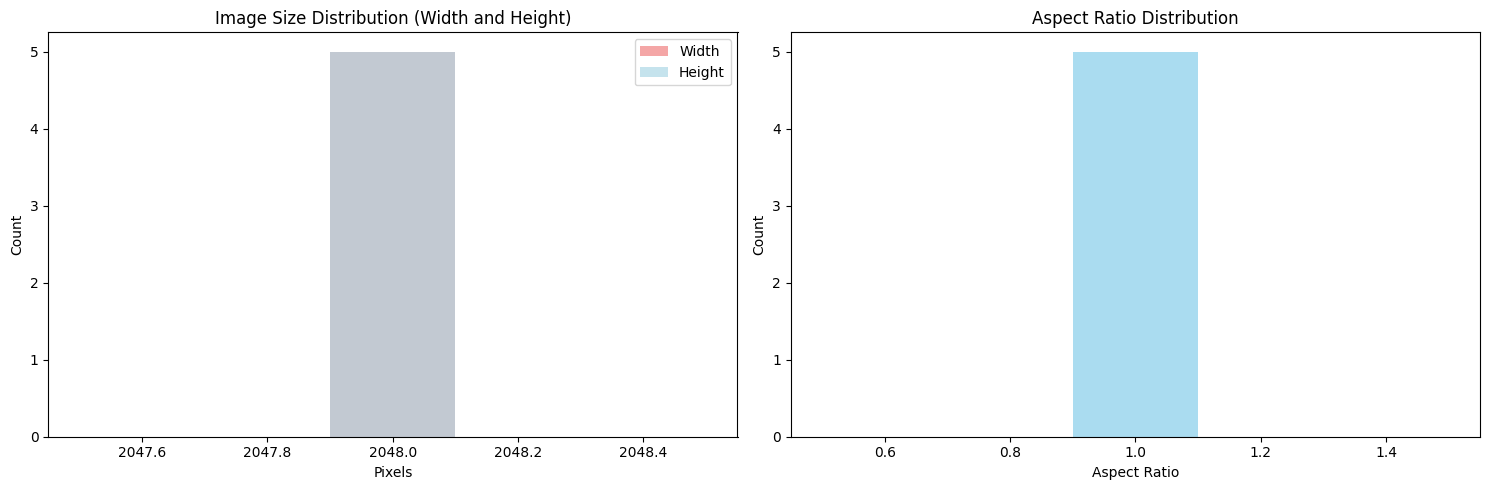

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sizes_df = pd.DataFrame(train_image_sizes, columns=["Width", "Height"])
# 이미지 크기 분포 시각화
axs[0].hist(sizes_df["Width"], bins=5, alpha=0.7, color="lightcoral", label='Width', orientation='vertical')
axs[0].hist(sizes_df["Height"], bins=5, alpha=0.7, color="lightblue", label='Height', orientation='vertical')
axs[0].set_xlabel("Pixels")
axs[0].set_ylabel("Count")
axs[0].set_title("Image Size Distribution (Width and Height)")
axs[0].legend()

# 종횡비 분포 시각화
axs[1].hist(train_aspect_ratios, bins=5, alpha=0.7, color="skyblue")
axs[1].set_xlabel("Aspect Ratio")
axs[1].set_ylabel("Count")
axs[1].set_title("Aspect Ratio Distribution")

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

# 클래스 분석

### 클래스 별 pixel 차지 비율

In [ ]:
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}

{'finger-1': 0, 'finger-2': 1, 'finger-3': 2, 'finger-4': 3, 'finger-5': 4, 'finger-6': 5, 'finger-7': 6, 'finger-8': 7, 'finger-9': 8, 'finger-10': 9, 'finger-11': 10, 'finger-12': 11, 'finger-13': 12, 'finger-14': 13, 'finger-15': 14, 'finger-16': 15, 'finger-17': 16, 'finger-18': 17, 'finger-19': 18, 'Trapezium': 19, 'Trapezoid': 20, 'Capitate': 21, 'Hamate': 22, 'Scaphoid': 23, 'Lunate': 24, 'Triquetrum': 25, 'Pisiform': 26, 'Radius': 27, 'Ulna': 28}


In [85]:
# 이미지 크기 정의
image_shape = (2048, 2048)
total_pixels = image_shape[0] * image_shape[1]

# 클래스별로 빈 리스트를 담은 딕셔너리 초기화
class_pixel_ratios = {class_label: [] for class_label in CLASSES}

In [86]:
import cv2

# JSON 파일을 순회하며 각 클래스의 픽셀 비율 계산
for json_file in train_jsons:
    label_path = os.path.join(TRAIN_LABEL_ROOT, json_file)
    
    # JSON 파일에서 주석 로드
    with open(label_path, "r") as f:
        annotations = json.load(f)["annotations"]
    
    # 클래스별 마스크 생성 및 픽셀 비율 계산
    class_masks = np.zeros(tuple(image_shape[:2]) + (len(CLASSES), ), dtype=np.uint8)

    # 주석 데이터에서 각 클래스에 대해 폴리곤 마스크 생성 후 픽셀 수 계산
    for ann in annotations:
        class_label = ann["label"]
        class_ind = CLASS2IND[class_label]
        points = np.array(ann["points"])
        
        # 각 클래스별 마스크 생성
        class_mask = np.zeros(image_shape[:2], dtype=np.uint8)
        cv2.fillPoly(class_mask, [points], 1)
        class_masks[..., class_ind] = class_mask
        
    # 각 클래스별 픽셀 비율 계산
    for i, class_label in enumerate(CLASSES):
        class_pixel_count = np.sum(class_masks[..., i] == 1)  # 해당 클래스의 픽셀 수
        pixel_ratio = class_pixel_count / total_pixels  # 비율 계산
        class_pixel_ratios[class_label].append((pixel_ratio, json_file))

In [ ]:
class_pixel_ratios["Radius"]

[(0.01792621612548828, 'ID001/image1661130828152_R.json'),
 (0.017110347747802734, 'ID001/image1661130891365_L.json'),
 (0.01715874671936035, 'ID002/image1661144206667.json'),
 (0.016402721405029297, 'ID002/image1661144246917.json'),
 (0.015609979629516602, 'ID003/image1661144310162.json'),
 (0.014252662658691406, 'ID003/image1661144351691.json'),
 (0.014243125915527344, 'ID004/image1661144691792.json'),
 (0.014833211898803711, 'ID004/image1661144724044.json'),
 (0.016909122467041016, 'ID005/image1661144825412.json'),
 (0.017352581024169922, 'ID005/image1661144852117.json'),
 (0.013151168823242188, 'ID006/image1661145075929.json'),
 (0.013781309127807617, 'ID006/image1661145103549.json'),
 (0.015001296997070312, 'ID007/image1661145193855.json'),
 (0.01431417465209961, 'ID007/image1661145229731.json'),
 (0.015516042709350586, 'ID008/image1661145286692.json'),
 (0.013026952743530273, 'ID008/image1661145313061.json'),
 (0.014976024627685547, 'ID009/image1661145407161.json'),
 (0.013771772

In [105]:
# 분석할 JSON 파일 경로 설정
json_file = train_jsons[2]  # 분석할 JSON 파일명 입력
print(json_file)
label_path = os.path.join(TRAIN_LABEL_ROOT, json_file)

# JSON 파일에서 주석 로드
with open(label_path, "r") as f:
    annotations = json.load(f)["annotations"]

# 클래스별 픽셀 차지 비율을 저장할 딕셔너리 초기화
class_pixel_ratios = {class_label: 0 for class_label in CLASSES}
total_pixels = image_shape[0] * image_shape[1]  # 전체 이미지 픽셀 수

# 클래스별 마스크 생성 및 픽셀 비율 계산
class_masks = np.zeros(tuple(image_shape[:2]) + (len(CLASSES), ), dtype=np.uint8)

for ann in annotations:
    class_label = ann["label"]
    class_ind = CLASS2IND[class_label]
    points = np.array(ann["points"])
    
    # 각 클래스별 마스크 생성
    class_mask = np.zeros(image_shape[:2], dtype=np.uint8)
    cv2.fillPoly(class_mask, [points], 1)
    class_masks[..., class_ind] = class_mask

# 각 클래스별 픽셀 비율 계산
for i, class_label in enumerate(CLASSES):
    class_pixel_count = np.sum(class_masks[..., i] == 1)  # 해당 클래스의 픽셀 수
    class_pixel_ratios[class_label] = class_pixel_count / total_pixels  # 비율 계산

# 결과 출력
for class_label, ratio in class_pixel_ratios.items():
    print(f"Class: {class_label}, Pixel Ratio: {ratio:.4f}")

ID002/image1661144206667.json
Class: finger-1, Pixel Ratio: 0.0019
Class: finger-2, Pixel Ratio: 0.0043
Class: finger-3, Pixel Ratio: 0.0072
Class: finger-4, Pixel Ratio: 0.0013
Class: finger-5, Pixel Ratio: 0.0027
Class: finger-6, Pixel Ratio: 0.0056
Class: finger-7, Pixel Ratio: 0.0090
Class: finger-8, Pixel Ratio: 0.0016
Class: finger-9, Pixel Ratio: 0.0036
Class: finger-10, Pixel Ratio: 0.0064
Class: finger-11, Pixel Ratio: 0.0084
Class: finger-12, Pixel Ratio: 0.0016
Class: finger-13, Pixel Ratio: 0.0032
Class: finger-14, Pixel Ratio: 0.0055
Class: finger-15, Pixel Ratio: 0.0059
Class: finger-16, Pixel Ratio: 0.0010
Class: finger-17, Pixel Ratio: 0.0018
Class: finger-18, Pixel Ratio: 0.0036
Class: finger-19, Pixel Ratio: 0.0065
Class: Trapezium, Pixel Ratio: 0.0023
Class: Trapezoid, Pixel Ratio: 0.0017
Class: Capitate, Pixel Ratio: 0.0040
Class: Hamate, Pixel Ratio: 0.0029
Class: Scaphoid, Pixel Ratio: 0.0031
Class: Lunate, Pixel Ratio: 0.0022
Class: Triquetrum, Pixel Ratio: 0.002

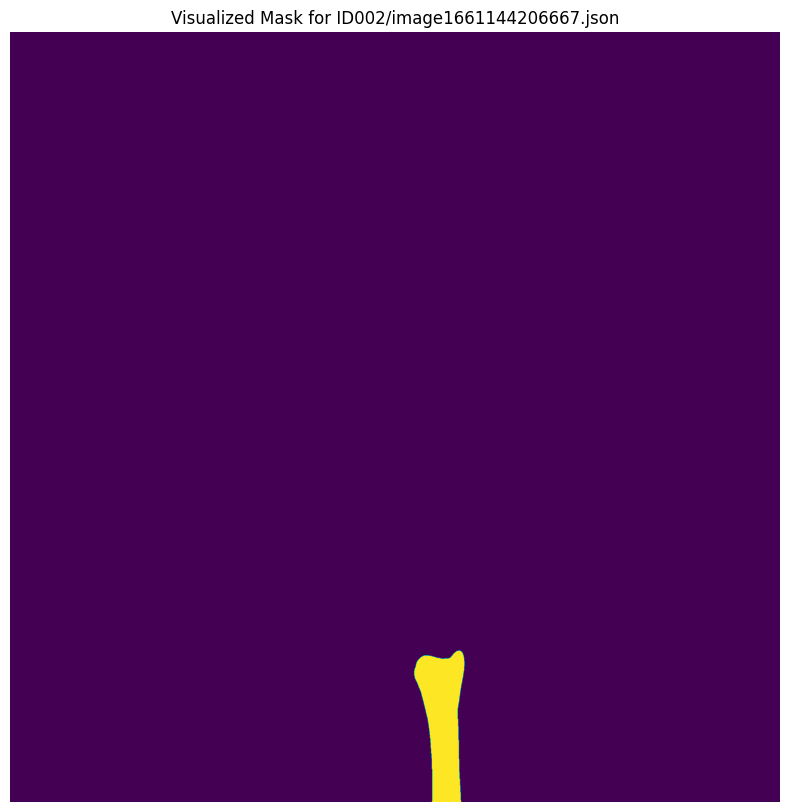

In [108]:
# 마스크 시각화
plt.figure(figsize=(10, 10))
plt.imshow(class_masks[..., -1])
plt.axis('off')
plt.title(f"Visualized Mask for {json_file}")
plt.show()

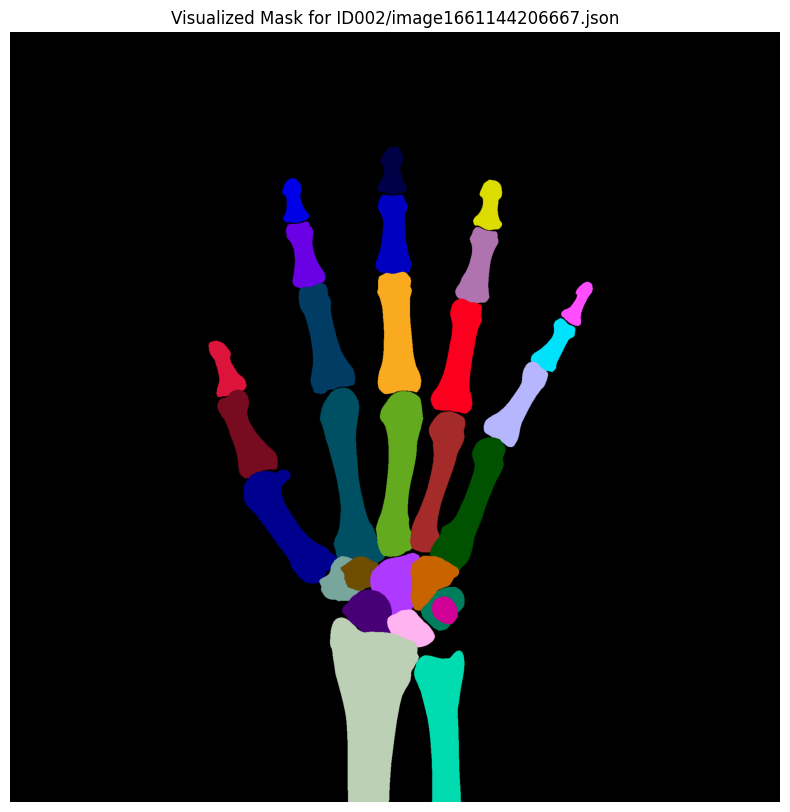

In [80]:
# 색상 팔레트 정의
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# 빈 RGB 마스크 이미지 생성
colored_mask = np.zeros((*image_shape[:2], 3), dtype=np.uint8)

# 각 클래스별로 마스크에 팔레트 색상을 할당
for i, class_label in enumerate(CLASSES):
    colored_mask[class_masks[..., i] == 1] = PALETTE[i]

# 마스크 시각화
plt.figure(figsize=(10, 10))
plt.imshow(colored_mask)
plt.axis('off')
plt.title(f"Visualized Mask for {json_file}")
plt.show()


#### 1. 시각화

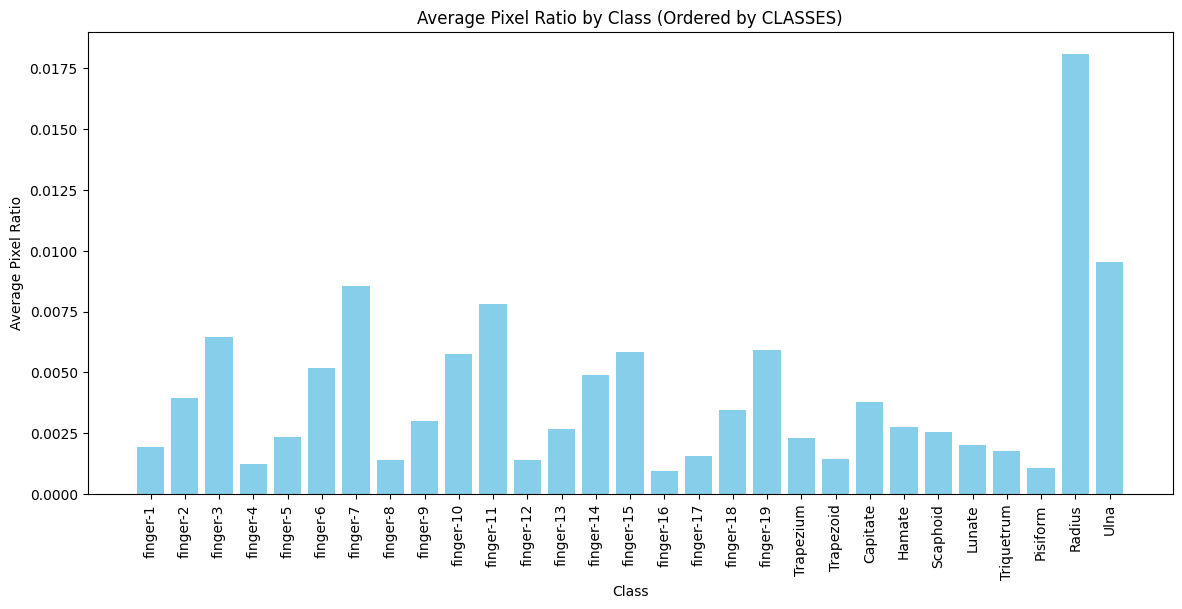

In [ ]:
# CLASSES 순서로 클래스별 평균 픽셀 비율 계산
average_pixel_ratios = {class_label: np.mean([ratio[0] for ratio in class_pixel_ratios.get(class_label, [])]) 
                        for class_label in CLASSES}

# 시각화를 위해 CLASSES 순서에 맞춰 정렬
classes, avg_ratios = zip(*[(class_label, average_pixel_ratios[class_label]) for class_label in CLASSES])

# 클래스별 평균 픽셀 비율 시각화 (x축에 클래스, y축에 비율)
plt.figure(figsize=(14, 6))
plt.bar(classes, avg_ratios, color="skyblue")
plt.ylabel("Average Pixel Ratio")
plt.xlabel("Class")
plt.xticks(rotation=90)  # x축 레이블 회전
plt.title("Average Pixel Ratio by Class")
plt.show()

##### 2. 클래스별 픽셀 비율 최소 및 최대인 파일

In [90]:
# 클래스별 픽셀 비율 최소 및 최대인 파일 찾기
min_max_pixel_ratios = {}
for class_label, ratios in class_pixel_ratios.items():
    min_ratio, min_file = min(ratios, key=lambda x: x[0])
    max_ratio, max_file = max(ratios, key=lambda x: x[0])
    min_max_pixel_ratios[class_label] = {
        "min_ratio": min_ratio,
        "min_file": min_file,
        "max_ratio": max_ratio,
        "max_file": max_file,
    }

In [91]:
# 결과 출력
for class_label, stats in min_max_pixel_ratios.items():
    print(f"Class: {class_label}")
    print(f"  Min Pixel Ratio: {stats['min_ratio']:.4f} in {stats['min_file']}")
    print(f"  Max Pixel Ratio: {stats['max_ratio']:.4f} in {stats['max_file']}")
    print()

Class: finger-1
  Min Pixel Ratio: 0.0012 in ID468/image1666659890125.json
  Max Pixel Ratio: 0.0076 in ID058/image1661392103627.json

Class: finger-2
  Min Pixel Ratio: 0.0028 in ID003/image1661144351691.json
  Max Pixel Ratio: 0.0058 in ID409/image1665540974169.json

Class: finger-3
  Min Pixel Ratio: 0.0022 in ID058/image1661392103627.json
  Max Pixel Ratio: 0.0092 in ID436/image1666060344877.json

Class: finger-4
  Min Pixel Ratio: 0.0008 in ID468/image1666659890125.json
  Max Pixel Ratio: 0.0021 in ID477/image1666660769825.json

Class: finger-5
  Min Pixel Ratio: 0.0017 in ID468/image1666659890125.json
  Max Pixel Ratio: 0.0037 in ID477/image1666660769825.json

Class: finger-6
  Min Pixel Ratio: 0.0037 in ID079/image1661737310510.json
  Max Pixel Ratio: 0.0074 in ID425/image1666059406855.json

Class: finger-7
  Min Pixel Ratio: 0.0062 in ID079/image1661737310510.json
  Max Pixel Ratio: 0.0120 in ID344/image1664932490676.json

Class: finger-8
  Min Pixel Ratio: 0.0009 in ID375/imag

In [109]:
# 경로 설정
output_dir = "/data/ephemeral/home/output/"
os.makedirs(output_dir, exist_ok=True)

# 클래스별 색상 매핑
CLASS_TO_COLOR = {class_label: PALETTE[i] for i, class_label in enumerate(CLASSES)}
alpha = 0.5  # 투명도

# 각 클래스별 작업 수행
for class_label, stats in min_max_pixel_ratios.items():
    # min 및 max 파일의 경로 설정 및 json 확장자 변경
    min_file = stats["min_file"].replace(".json", ".png")
    max_file = stats["max_file"].replace(".json", ".png")
    min_src_path = os.path.join(TRAIN_IMAGE_ROOT, min_file)
    max_src_path = os.path.join(TRAIN_IMAGE_ROOT, max_file)

    # subplot 설정
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"Class: {class_label}", fontsize=14)
    
       # min 및 max 파일에 대해 처리
    for idx, (src_path, label, ax) in enumerate(zip([min_src_path, max_src_path], ["min", "max"], axes)):
        if os.path.exists(src_path):
            # 원본 이미지 로드
            image = cv2.imread(src_path)
            overlay = image.copy()
            
            # 클래스별 마스크 생성
            mask = np.zeros(image.shape[:2], dtype=np.uint8)
            json_path = os.path.join(TRAIN_LABEL_ROOT, stats[f"{label}_file"].replace(".png", ".json"))
            with open(json_path, "r") as f:
                annotations = json.load(f)["annotations"]
            
            # 해당 클래스의 폴리곤 마스크 생성
            for ann in annotations:
                if ann["label"] == class_label:
                    points = np.array(ann["points"], dtype=np.int32)
                    cv2.fillPoly(mask, [points], 1)
            
            # 마스크를 이미지에 덧씌움
            mask_color = CLASS_TO_COLOR[class_label]  # 클래스에 해당하는 색상 할당
            overlay[mask > 0] = mask_color  # 마스크 부분을 색상으로 채움
            masked_image = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)  # 투명도 적용
            
            # subplot에 이미지 표시
            ax.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
            ax.axis("off")
            ax.set_title(f"{os.path.basename(json_path).replace('.json', '.png')}_{label}")
        else:
            print(f"File not found: {src_path}")

    # subplot 저장
    save_path = os.path.join(output_dir, f"{class_label}_masked_min_max.png")
    plt.savefig(save_path)
    plt.close(fig)  # 메모리 관리를 위해 subplot 닫기
    print(f"Saved subplot image to {save_path}")

Saved subplot image to /data/ephemeral/home/output/finger-1_masked_min_max.png
Saved subplot image to /data/ephemeral/home/output/finger-2_masked_min_max.png
Saved subplot image to /data/ephemeral/home/output/finger-3_masked_min_max.png
Saved subplot image to /data/ephemeral/home/output/finger-4_masked_min_max.png
Saved subplot image to /data/ephemeral/home/output/finger-5_masked_min_max.png
Saved subplot image to /data/ephemeral/home/output/finger-6_masked_min_max.png
Saved subplot image to /data/ephemeral/home/output/finger-7_masked_min_max.png
Saved subplot image to /data/ephemeral/home/output/finger-8_masked_min_max.png
Saved subplot image to /data/ephemeral/home/output/finger-9_masked_min_max.png
Saved subplot image to /data/ephemeral/home/output/finger-10_masked_min_max.png
Saved subplot image to /data/ephemeral/home/output/finger-11_masked_min_max.png
Saved subplot image to /data/ephemeral/home/output/finger-12_masked_min_max.png
Saved subplot image to /data/ephemeral/home/outpu

#### 클래스 간 겹치는 픽셀 수

In [52]:
IMAGE_SHAPE = (2048, 2048)

# 클래스 간 겹치는 영역을 저장할 매트릭스 초기화
overlap_matrix = np.zeros((len(CLASSES), len(CLASSES)), dtype=np.float32)

# JSON 파일을 순회하며 겹치는 영역 분석
for json_file in train_jsons:
    label_path = os.path.join(TRAIN_LABEL_ROOT, json_file)

    # JSON 파일에서 주석 로드
    with open(label_path, "r") as f:
        annotations = json.load(f)["annotations"]

    # 클래스별 마스크 생성
    class_masks = np.zeros((len(CLASSES), *IMAGE_SHAPE), dtype=np.uint8)
    
    for ann in annotations:
        class_label = ann["label"]
        class_index = CLASSES.index(class_label)
        points = np.array(ann["points"])
        
        # 각 클래스별 마스크 생성
        cv2.fillPoly(class_masks[class_index], [points], 1)

    # 클래스 쌍 간 겹치는 영역 계산
    for i in range(len(CLASSES)):
        for j in range(i + 1, len(CLASSES)):
            overlap_area = np.sum((class_masks[i] & class_masks[j]) > 0)
            overlap_matrix[j, i] += overlap_area
            overlap_matrix[i, j] = np.nan  # 대칭으로 저장

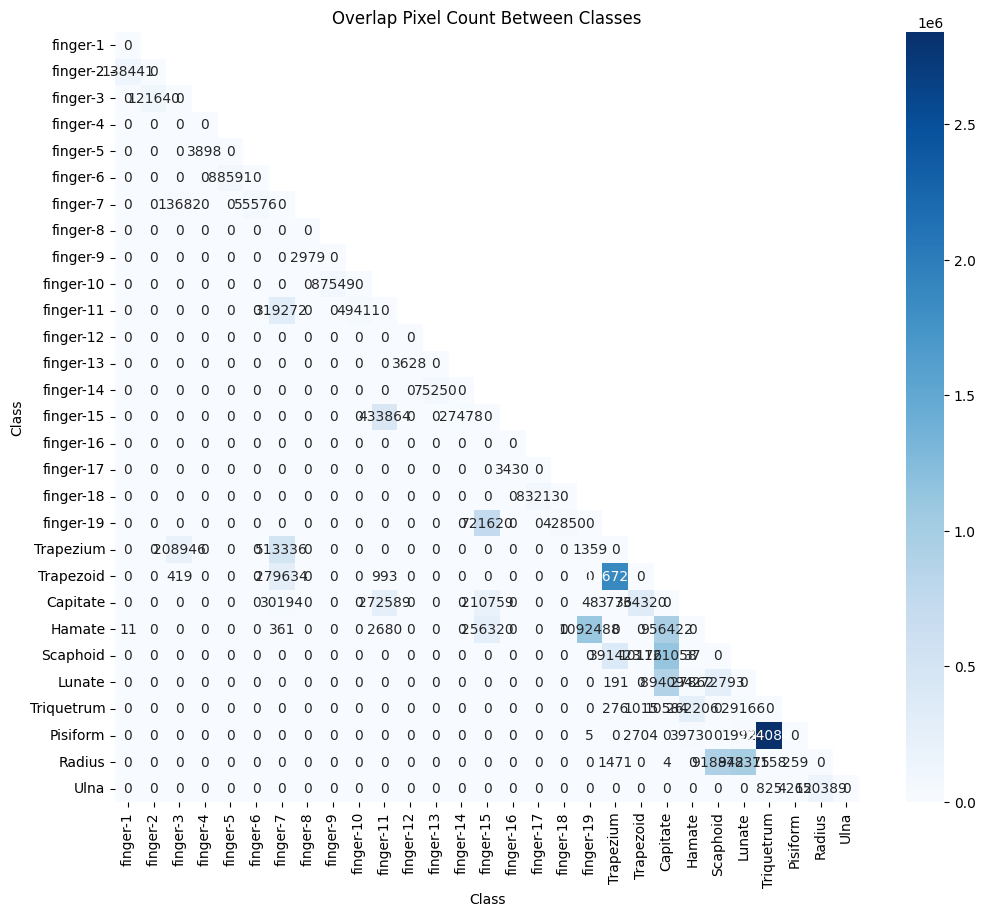

In [53]:
# 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(overlap_matrix, annot=True, fmt=".0f", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Class")
plt.ylabel("Class")
plt.title("Overlap Pixel Count Between Classes")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()